In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA

from sklearn.model_selection import train_test_split
from keras.models import Sequential
pd.pandas.set_option('display.max_columns', None)
from pmdarima import auto_arima

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Chicago_Traffic_Tracker_Monthly.csv', parse_dates=True)
df.head()

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
0,06/14/2018 05:20:48 AM,7,23.18,Hermosa-Logan Square,26,372,5,5,6,North Ave to Diversy. Cicero to Ravenswood,07-201806141020,-87.747456,-87.674590,41.909269,41.931841,POINT (-87.747456 41.931841),POINT (-87.67459 41.909269)
1,06/14/2018 05:20:48 AM,8,23.86,Lincoln Park-Lake View,34,534,5,5,6,North Ave to Montrose. Ravenswood to Lake Shore,08-201806141020,-87.674590,-87.619112,41.910561,41.960669,POINT (-87.67459 41.960669),POINT (-87.619112 41.910561)
2,06/14/2018 05:20:48 AM,10,25.70,Humboldt-Garfield Prk E/W,48,684,5,5,6,Roosevelt to North Ave. Cicero to Rockwell,10-201806141020,-87.747456,-87.691617,41.866129,41.909269,POINT (-87.747456 41.909269),POINT (-87.691617 41.866129)
3,06/14/2018 05:20:48 AM,12,24.61,Near North,15,210,5,5,6,Wacker to North. Halsted to Michigan,12-201806141020,-87.647208,-87.623080,41.888860,41.911401,POINT (-87.647208 41.911401),POINT (-87.62308 41.88886)
4,06/14/2018 05:20:48 AM,13,21.82,Chicago Loop,31,396,5,5,6,Roosevelt to Wacker: Halsted to Michigan,13-201806141020,-87.647208,-87.623080,41.866129,41.888860,POINT (-87.647208 41.88886),POINT (-87.62308 41.866129)


In [3]:
u_Region = df['REGION'].unique()
u_Region

array(['Hermosa-Logan Square', 'Lincoln Park-Lake View',
       'Humboldt-Garfield Prk E/W', 'Near North', 'Chicago Loop',
       'Lawndale N/S', 'Bridgeport-McKinley-Lower West',
       'South West Side', 'Hyde Park-Kenwood-Woodlawn', 'Ashburn',
       'Auburn Gresham-Chatham', 'Beverly-Mt Greenwood-Morgan Park',
       'Rogers Park - West Ridge', 'Far North West',
       'North Park-Albany-Linconl Sq', 'Edge Water-Uptown',
       'Dunning-Portage-Belmont Cragn', 'Austin',
       'Midway-Garfield Rdg-Clearing', 'Irving Park-Avondale-North Ctr',
       'West Town-Near West', 'Washington Hts-Roseland-Pullman',
       'Downtown Lakefront', 'Riverdale-Hegewisch',
       'New City-Englewood-W Englewood', 'South Deering-East Side',
       'South Shore-S Chicago-Avlon', 'Fuller-Grand Blvd-Washington Park',
       'Near South-Douglas'], dtype=object)

In [4]:
df_Austin = df[df['REGION']=='Austin']
df_Austin.head()

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
20,05/20/2018 08:10:33 AM,9,25.91,Austin,11,125,8,1,5,Roosevelt to North Ave. Austin to Cicero,09-201805201310,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
51,03/13/2018 09:40:38 AM,9,22.16,Austin,27,406,9,3,3,Roosevelt to North Ave. Austin to Cicero,09-201803131440,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
80,03/13/2018 06:31:33 PM,9,22.50,Austin,38,539,18,3,3,Roosevelt to North Ave. Austin to Cicero,09-201803132331,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
109,03/13/2018 09:50:55 AM,9,22.50,Austin,24,355,9,3,3,Roosevelt to North Ave. Austin to Cicero,09-201803131450,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
139,03/14/2018 04:10:21 AM,9,32.73,Austin,6,64,4,4,3,Roosevelt to North Ave. Austin to Cicero,09-201803140910,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)


In [5]:
df_Austin.shape

(101189, 17)

In [6]:
df_Austin['SPEED'].max()

87.99

In [7]:
df_Austin['TIME'].max()

'12/31/2019 12:51:09 PM'

In [8]:
df_Austin['TIME'].min()

'01/01/2019 01:01:38 PM'

In [9]:
df_Austin=df_Austin.sort_values(by='TIME')
df_Austin.head()

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
1238003,01/01/2019 01:01:38 PM,9,23.86,Austin,22,536,13,3,1,Roosevelt to North Ave. Austin to Cicero,09-201901011901,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
1233999,01/01/2019 01:10:27 AM,9,0.00,Austin,3,96,1,3,1,Roosevelt to North Ave. Austin to Cicero,09-201901010710,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
1238061,01/01/2019 01:10:48 PM,9,25.23,Austin,18,401,13,3,1,Roosevelt to North Ave. Austin to Cicero,09-201901011910,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
1234056,01/01/2019 01:21:00 AM,9,0.00,Austin,1,7,1,3,1,Roosevelt to North Ave. Austin to Cicero,09-201901010721,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
1238131,01/01/2019 01:21:06 PM,9,26.59,Austin,19,446,13,3,1,Roosevelt to North Ave. Austin to Cicero,09-201901011921,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)


In [10]:
df_Austin.shape

(101189, 17)

In [11]:
df.shape

(2934457, 17)

In [12]:
df_Austin.describe()

,REGION_ID,SPEED,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,WEST,EAST,SOUTH,NORTH
count,101189.0,101189.000000,101189.000000,101189.000000,101189.000000,101189.000000,101189.000000,1.011890e+05,1.011890e+05,101189.000000,1.011890e+05
mean,9.0,21.984348,19.667286,377.245175,11.513168,4.022918,6.311101,-8.777595e+01,-8.774746e+01,41.866129,4.190927e+01
std,0.0,8.606143,11.166828,234.356560,6.914494,1.986494,3.396017,1.421092e-14,4.263277e-14,0.000000,7.105462e-15
min,9.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-8.777595e+01,-8.774746e+01,41.866129,4.190927e+01
25%,9.0,22.500000,11.000000,209.000000,6.000000,2.000000,3.000000,-8.777595e+01,-8.774746e+01,41.866129,4.190927e+01
50%,9.0,24.550000,20.000000,358.000000,12.000000,4.000000,6.000000,-8.777595e+01,-8.774746e+01,41.866129,4.190927e+01
75%,9.0,25.910000,28.000000,537.000000,17.000000,6.000000,9.000000,-8.777595e+01,-8.774746e+01,41.866129,4.190927e+01
max,9.0,87.990000,50.000000,2713.000000,23.000000,7.000000,12.000000,-8.777595e+01,-8.774746e+01,41.866129,4.190927e+01


In [13]:
df_Austin['SPEED'].isnull().count()

101189

In [14]:
df_Austin['TIME'] = df_Austin['TIME'].astype('datetime64[ns]')

In [15]:
df_Austin=df_Austin.sort_values(by='TIME')


In [16]:
df_Austin.head()

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
20379,2018-03-09 15:40:41,9,19.77,Austin,34,572,15,6,3,Roosevelt to North Ave. Austin to Cicero,09-201803092140,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
23699,2018-03-09 15:50:56,9,19.09,Austin,33,501,15,6,3,Roosevelt to North Ave. Austin to Cicero,09-201803092150,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
19206,2018-03-09 16:01:45,9,20.45,Austin,38,592,16,6,3,Roosevelt to North Ave. Austin to Cicero,09-201803092201,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
16402,2018-03-09 16:10:55,9,19.09,Austin,36,570,16,6,3,Roosevelt to North Ave. Austin to Cicero,09-201803092210,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
26395,2018-03-09 16:21:17,9,20.45,Austin,34,549,16,6,3,Roosevelt to North Ave. Austin to Cicero,09-201803092221,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)


In [17]:
df_Austin.tail()

,TIME,REGION_ID,SPEED,REGION,BUS_COUNT,NUM_READS,HOUR,DAY_OF_WEEK,MONTH,DESCRIPTION,RECORD_ID,WEST,EAST,SOUTH,NORTH,NW_LOCATION,SE_LOCATION
2912905,2020-04-10 13:51:01,9,25.91,Austin,31,553,13,6,4,Roosevelt to North Ave. Austin to Cicero,09-202004101851,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
2912960,2020-04-10 14:01:48,9,25.23,Austin,33,660,14,6,4,Roosevelt to North Ave. Austin to Cicero,09-202004101901,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
2913022,2020-04-10 14:11:00,9,25.23,Austin,29,681,14,6,4,Roosevelt to North Ave. Austin to Cicero,09-202004101911,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
2913102,2020-04-10 14:21:21,9,25.16,Austin,25,522,14,6,4,Roosevelt to North Ave. Austin to Cicero,09-202004101921,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)
2913160,2020-04-10 14:31:35,9,25.23,Austin,29,694,14,6,4,Roosevelt to North Ave. Austin to Cicero,09-202004101931,-87.775947,-87.747456,41.866129,41.909269,POINT (-87.775947 41.909269),POINT (-87.747456 41.866129)


In [18]:
start= pd.Timestamp("2018-03-09 15:40:41")
end = pd.Timestamp("2020-4-10 14-31-35")

In [19]:
df_Austin_con = df_Austin[['TIME','SPEED','BUS_COUNT','NUM_READS']]

In [20]:
df_Austin_con.shape

(101189, 4)

In [21]:
# df_Austin_con['CONG']= df_Austin_con[df_Austin_con['SPEED']/40]
df_Austin_con['CONG'] = df_Austin_con['SPEED'].map(lambda x: float(x/40))

C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df_Austin_con.head()

,TIME,SPEED,BUS_COUNT,NUM_READS,CONG
20379,2018-03-09 15:40:41,19.77,34,572,0.49425
23699,2018-03-09 15:50:56,19.09,33,501,0.47725
19206,2018-03-09 16:01:45,20.45,38,592,0.51125
16402,2018-03-09 16:10:55,19.09,36,570,0.47725
26395,2018-03-09 16:21:17,20.45,34,549,0.51125


In [23]:
df_Austin_con.shape

(101189, 5)

In [24]:
df_Aus_Cong= df_Austin_con[['TIME','CONG']]
df_Aus_Cong.shape

(101189, 2)

In [25]:
df_Aus_Cong.head(5)

,TIME,CONG
20379,2018-03-09 15:40:41,0.49425
23699,2018-03-09 15:50:56,0.47725
19206,2018-03-09 16:01:45,0.51125
16402,2018-03-09 16:10:55,0.47725
26395,2018-03-09 16:21:17,0.51125


In [26]:
df_Aus_Cong = df_Aus_Cong[(df_Aus_Cong['TIME']>='2018-03-10 00:10:28') & (df_Aus_Cong['TIME']<'2020-04-10  00:01:29') ]

In [27]:
df_Aus_Cong.head(5)

,TIME,CONG
20431,2018-03-10 00:10:28,0.00000
26595,2018-03-10 00:20:44,0.68175
14079,2018-03-10 00:40:13,0.73300
17632,2018-03-10 00:50:27,0.00000
21260,2018-03-10 01:10:24,0.00000


In [28]:
df_Aus_Cong.tail(6)

,TIME,CONG
2906103,2020-04-09 23:01:33,0.66475
2906181,2020-04-09 23:10:50,0.68175
2906254,2020-04-09 23:21:08,0.71600
2906306,2020-04-09 23:31:25,0.78400
2906364,2020-04-09 23:40:21,0.71600
2906451,2020-04-09 23:50:40,0.69875


In [29]:
df_Aus_Cong.set_index('TIME',inplace=True)

In [30]:
df_Aus_Cong.head()

,CONG
TIME,
2018-03-10 00:10:28,0.00000
2018-03-10 00:20:44,0.68175
2018-03-10 00:40:13,0.73300
2018-03-10 00:50:27,0.00000
2018-03-10 01:10:24,0.00000


In [31]:
output = df_Aus_Cong.resample('D').mean()
output.head()

,CONG
TIME,
2018-03-10,0.486151
2018-03-11,0.531629
2018-03-12,0.524233
2018-03-13,0.516991
2018-03-14,0.515276


In [32]:
day = df_Austin_con[(df_Austin_con['TIME']>='2018-03-10 00:10:28') & (df_Austin_con['TIME']<='2018-03-11 00:10:20') ]
day.shape

(114, 5)

In [33]:
day.head()

,TIME,SPEED,BUS_COUNT,NUM_READS,CONG
20431,2018-03-10 00:10:28,0.00,3,51,0.00000
26595,2018-03-10 00:20:44,27.27,10,189,0.68175
14079,2018-03-10 00:40:13,29.32,7,109,0.73300
17632,2018-03-10 00:50:27,0.00,4,46,0.00000
21260,2018-03-10 01:10:24,0.00,2,24,0.00000


In [34]:
day.tail()

,TIME,SPEED,BUS_COUNT,NUM_READS,CONG
19425,2018-03-10 23:10:30,26.59,12,197,0.66475
22788,2018-03-10 23:20:48,24.55,10,152,0.61375
18702,2018-03-10 23:31:03,28.84,8,95,0.72100
16337,2018-03-10 23:40:14,24.55,10,136,0.61375
26779,2018-03-10 23:50:29,24.55,9,120,0.61375


In [35]:
s=day['CONG'].sum()

In [36]:
s/114

0.48615131578947374

In [37]:
output.shape

(762, 1)

In [38]:
# df_nan= pd.DataFrame(output).set_index('CONG')

In [39]:
df1 = output[output.isna().any(axis=1)]

In [40]:
df1.shape

(11, 1)

In [41]:
df1

,CONG
TIME,
2018-04-15,NaN
2018-08-12,NaN
2018-11-18,NaN
2019-01-12,NaN
2019-01-13,NaN
2019-11-11,NaN
2019-12-13,NaN
2019-12-14,NaN
2019-12-15,NaN


In [42]:
# output.groupby([output.index.day]).transform(lambda x: x.fillna(x.mean()))
# output.fillna(output.mean(axis=0))

In [43]:
[output['CONG'].fillna(output['CONG'].mean(), inplace=True) for col in output.columns]

[None]

In [44]:
df1 = output[output.isna().any(axis=1)]
df1.head(15)

,CONG
TIME,


C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


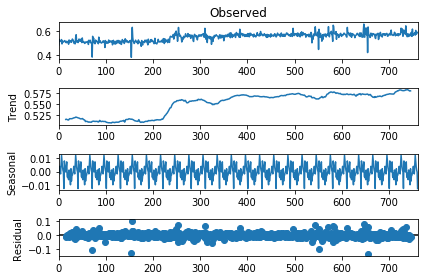

In [45]:
result = seasonal_decompose(output.CONG.values, freq=30)  # model='mul' also works
result.plot();

In [46]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [47]:
adf_test(output)

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.936333
p-value                   0.315166
# lags used               9.000000
# observations          752.000000
critical value (1%)      -3.439076
critical value (5%)      -2.865391
critical value (10%)     -2.568821
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


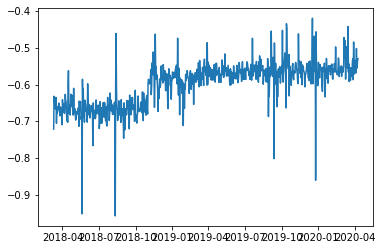

In [48]:
df_log = np.log(output)
plt.plot(df_log)

In [49]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

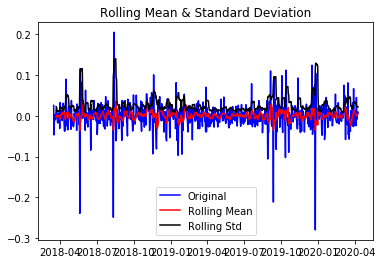

In [50]:
rolling_mean = df_log.rolling(window=7).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

In [51]:
adf_test(df_log_minus_mean)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.202832e+01
p-value                 2.913676e-22
# lags used             8.000000e+00
# observations          7.470000e+02
critical value (1%)    -3.439134e+00
critical value (5%)    -2.865417e+00
critical value (10%)   -2.568834e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


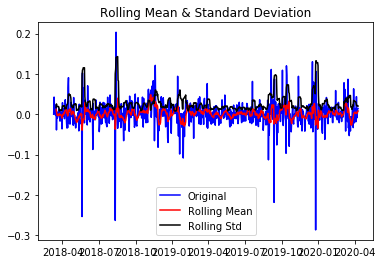

In [52]:
rolling_mean_exp_decay = df_log.ewm(halflife=7, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

In [53]:
adf_test(df_log_exp_decay)

Augmented Dickey-Fuller Test: 
ADF test statistic      -21.656077
p-value                   0.000000
# lags used               1.000000
# observations          760.000000
critical value (1%)      -3.438984
critical value (5%)      -2.865350
critical value (10%)     -2.568799
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


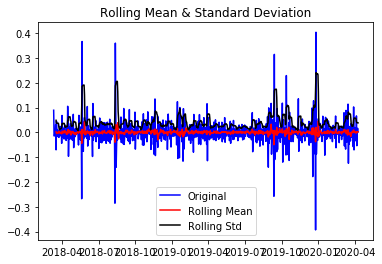

In [54]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [55]:
adf_test(df_log_shift)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.190227e+01
p-value                 5.539440e-22
# lags used             1.200000e+01
# observations          7.480000e+02
critical value (1%)    -3.439123e+00
critical value (5%)    -2.865412e+00
critical value (10%)   -2.568832e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [56]:
auto_arima(df_log_exp_decay,seasonal=True,m=7).summary()

C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likel

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  762
Model:             SARIMAX(0, 0, 2)x(1, 0, [1], 7)   Log Likelihood                1505.497
Date:                             Sat, 11 Apr 2020   AIC                          -2998.995
Time:                                     05:24:30   BIC                          -2971.179
Sample:                                          0   HQIC                         -2988.285
                                             - 762                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.261e-06   2.46e-05      0.255      0.799   -4.19e-05    5.45e-05
ma.L1         -0.0471      0.021     -2.200      0.028      -0.089      -0.005
ma.L2         -0.0678      0.024     -2.809      0.005      -0.115      -0.020
ar.S.L7        0.9923      0.008    124.902      0.000       0.977       1.008
ma.S.L7       -0.9691      0.018    -52.793      0.000      -1.005      -0.933
sigma2         0.0011   2.12e-05     52.983      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       19.55   Jarque-Bera (JB):             12609.11
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -1.82
Prob(H) (two-sided):                  0.25   Kurtosis:                        22.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
len(df_log_exp_decay)

762

In [58]:
train = df_log_exp_decay.iloc[:600]
test = df_log_exp_decay.iloc[600:]

In [59]:
model = SARIMAX(train, order=(2,0,2), seasonal_order=(1,0,[1],7),enforce_invertibility=False)
results = model.fit()
results.summary()

C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                CONG   No. Observations:                  600
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood                1200.627
Date:                             Sat, 11 Apr 2020   AIC                          -2387.255
Time:                                     05:24:31   BIC                          -2356.476
Sample:                                 03-10-2018   HQIC                         -2375.273
                                      - 10-30-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2546      0.479     -0.532      0.595      -1.193       0.684
ar.L2         -0.0532      0.689     -0.077      0.938      -1.404       1.297
ma.L1          0.2669      0.485      0.551      0.582      -0.683       1.217
ma.L2         -0.0251      0.698     -0.036      0.971      -1.393       1.343
ar.S.L7        0.9971      0.005    219.566      0.000       0.988       1.006
ma.S.L7       -0.9785      0.018    -53.983      0.000      -1.014      -0.943
sigma2         0.0011   2.29e-05     46.272      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       18.12   Jarque-Bera (JB):              8029.22
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -1.61
Prob(H) (two-sided):                  0.04   Kurtosis:                        20.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2,0,2)(1,0,[1],7) Predictions')

[Text(0, 0.5, 'Level of Congestion'), Text(0.5, 0, '')]

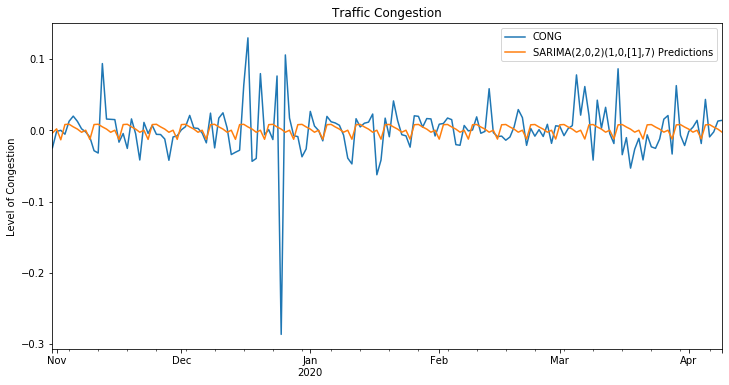

In [61]:
title='Traffic Congestion'
ylabel='Level of Congestion'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)